In [ ]:
%%capture
!pip install prophet
!pip install neuralprophet
!pip install arch
!pip install pmdarima
!pip install tabulate

In [213]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Пропускаем предупреждения
from warnings import filterwarnings
filterwarnings("ignore")

# Дополнительные импорты для моделей
from neuralprophet import NeuralProphet
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from arch import arch_model
import pmdarima as pm
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose

# Включаем отображение графиков в Jupyter Notebook
%matplotlib inline

# Функции оценки метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [162]:
data = pd.read_csv("https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip", compression='zip',parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<Figure size 1500x500 with 0 Axes>

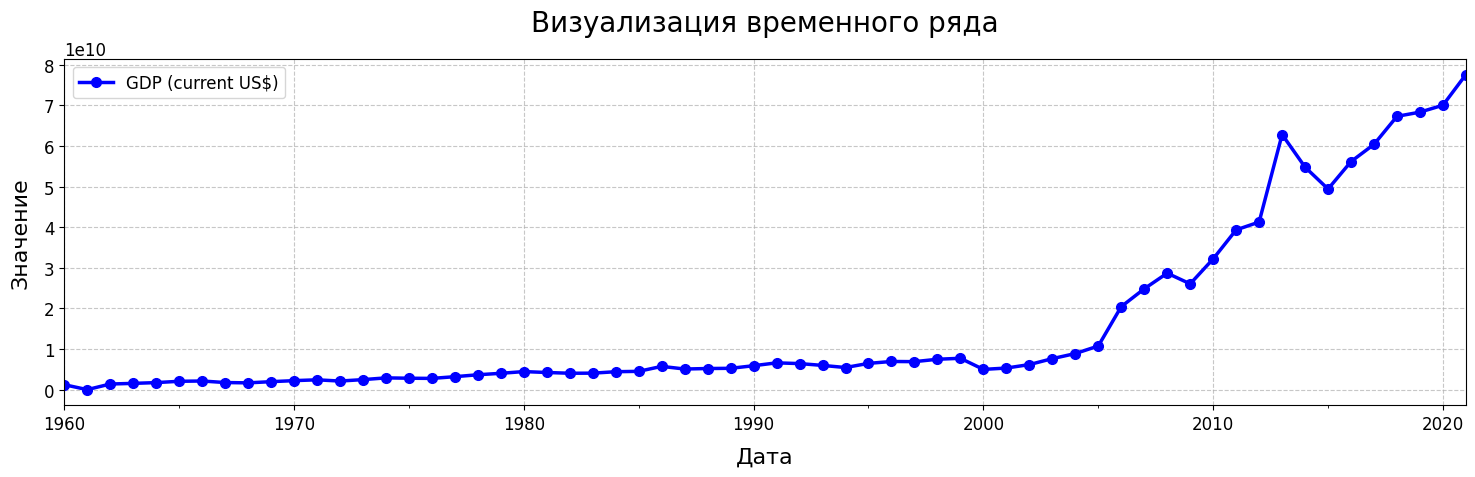

In [163]:
# Настройка параметров визуализации
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 2.5

# Построение графика
plt.figure(figsize=(15, 5));
data.plot(color='blue', linestyle='-', marker='o', markersize=7, label='Данные');

# Добавляем заголовок и подписи осей
plt.title("Визуализация временного ряда", fontsize=20, pad=20);
plt.xlabel("Дата", fontsize=16, labelpad=10)
plt.ylabel("Значение", fontsize=16, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='upper left');

plt.tight_layout();
plt.show();

Линия тренца имеет положительный наклон, что указывает на наличие восходящего тренда.
Очевиден долгосрочный рост ВВП, начиная с конца 1990-х годов и до 2020-х.

Наличие сезонности на данном графике не прослеживается.

## Отложим последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [164]:
# Разделяем данные на тренировочную и тестовую
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

## Проанализируем временной ряд на наличие тренда и сезонности.

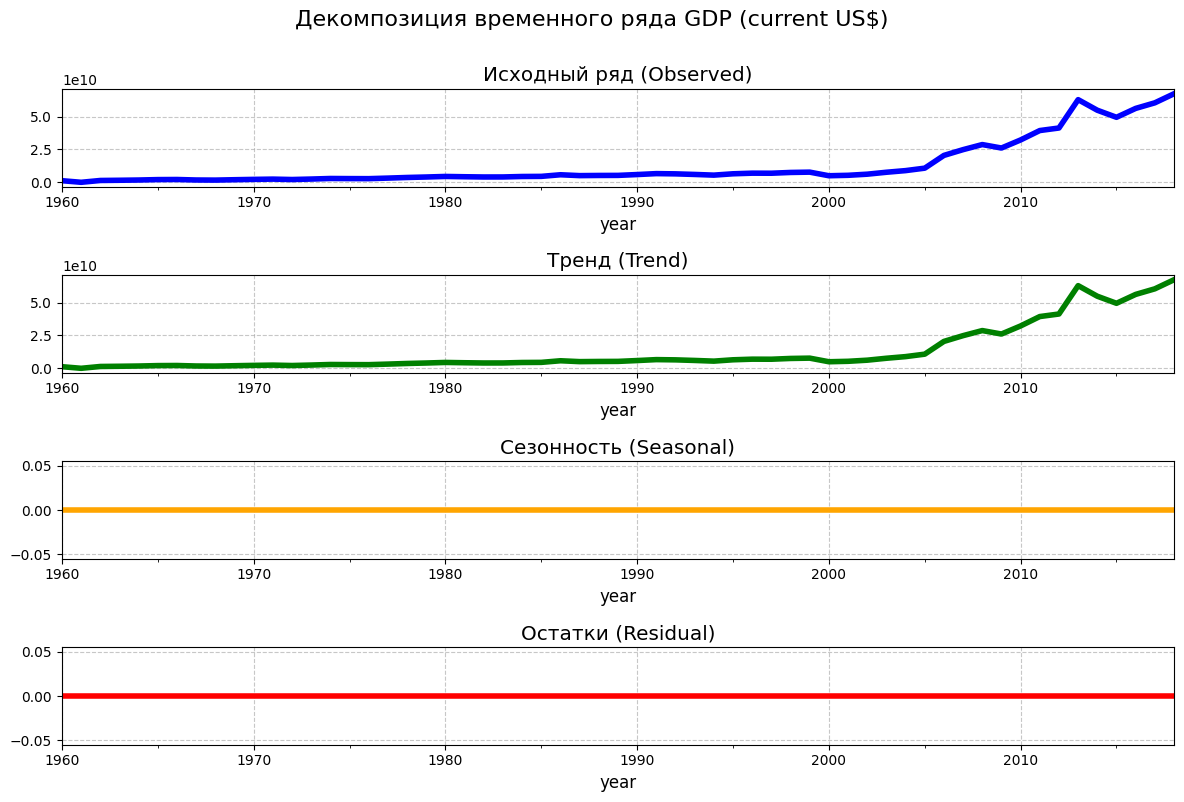

In [165]:
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 4

# Декомпозиция временного ряда
result = seasonal_decompose(train_df['GDP (current US$)'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

# Исходный ряд (Observed)
result.observed.plot(ax=ax1, color='blue', title='Исходный ряд (Observed)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Тренд (Trend)
result.trend.plot(ax=ax2, color='green', title='Тренд (Trend)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Сезонность (Seasonal)
result.seasonal.plot(ax=ax3, color='orange', title='Сезонность (Seasonal)')
ax3.grid(True, linestyle='--', alpha=0.7)

# Остатки (Residual)
result.resid.plot(ax=ax4, color='red', title='Остатки (Residual)')
ax4.grid(True, linestyle='--', alpha=0.7)

# Общие настройки
plt.suptitle("Декомпозиция временного ряда GDP (current US$)", fontsize=16, y=1)
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Сезонность и шум отсутствуют.

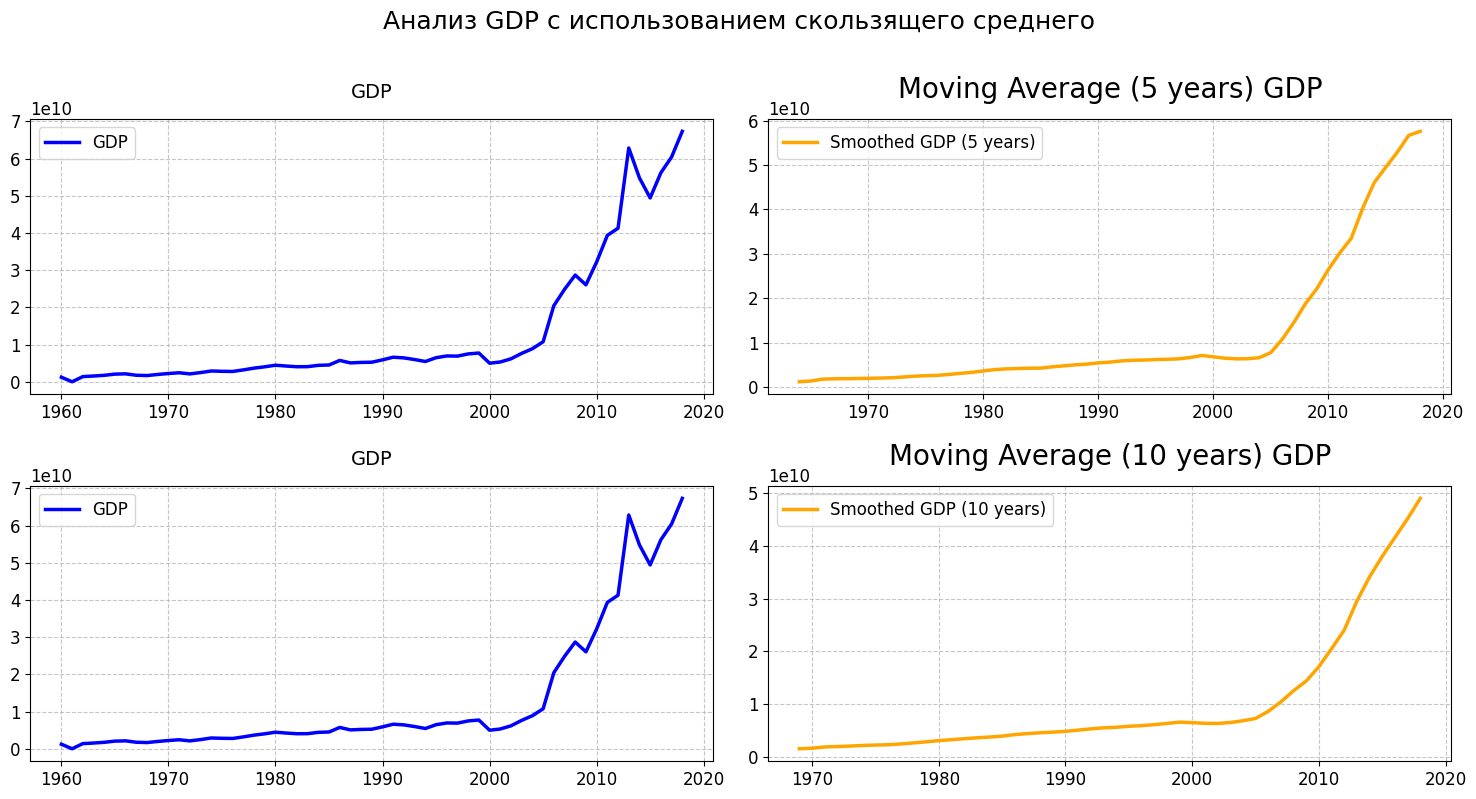

In [166]:
# Настройка параметров визуализации
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 2.5

# Создаем фигуру и оси
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# Окно в 5 лет
ax[0, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=14, pad=15)
ax[0, 0].legend(fontsize=12)
ax[0, 0].grid(True, linestyle='--', alpha=0.7)

ax[0, 1].plot(
    train_df['GDP (current US$)'].rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP (5 years)",
)
ax[0, 1].set_title("Moving Average (5 years) GDP", size=20, pad=15)
ax[0, 1].legend(fontsize=12)
ax[0, 1].grid(True, linestyle='--', alpha=0.7)

# Окно в 10 лет
ax[1, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP")
ax[1, 0].set_title("GDP", size=14, pad=15)
ax[1, 0].legend(fontsize=12)
ax[1, 0].grid(True, linestyle='--', alpha=0.7)

ax[1, 1].plot(
    train_df['GDP (current US$)'].rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP (10 years)",
)
ax[1, 1].set_title("Moving Average (10 years) GDP", size=20, pad=15)
ax[1, 1].legend(fontsize=12)
ax[1, 1].grid(True, linestyle='--', alpha=0.7)

# Общие настройки
plt.suptitle("Анализ GDP с использованием скользящего среднего", fontsize=18, y=1)
plt.tight_layout()
plt.show()


На графиках скользящего среднего также отчетливо прослеживается тренд. Благодаря графикам скользящего среднего тренд виден более явно.

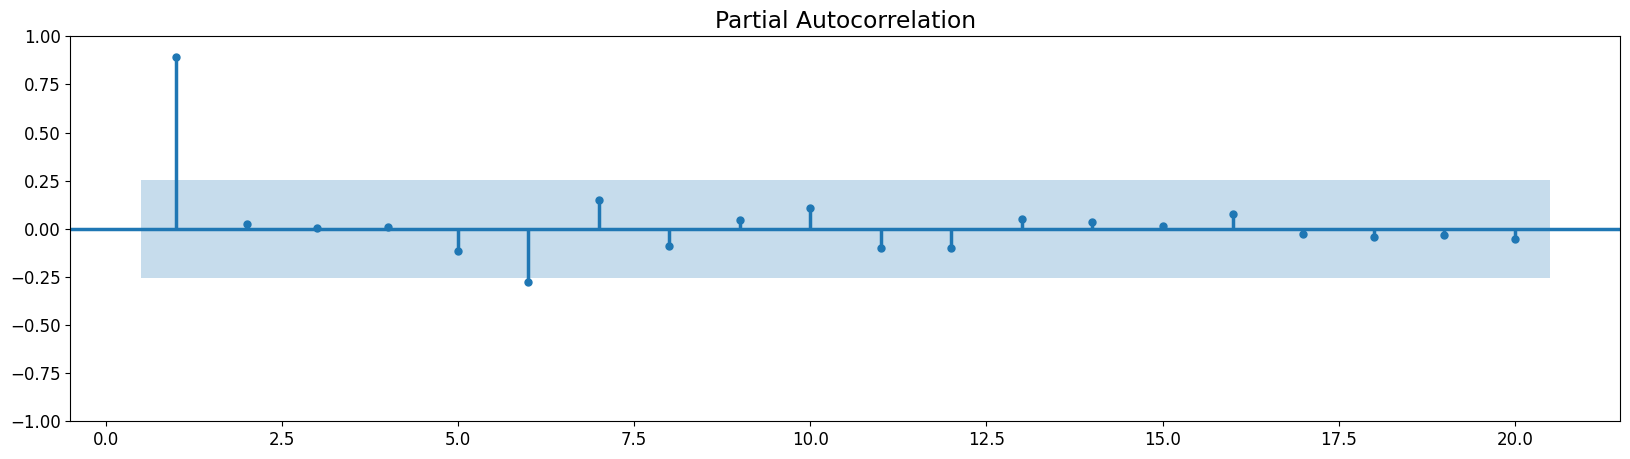

In [167]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False)
plt.show()

<Figure size 1800x500 with 0 Axes>

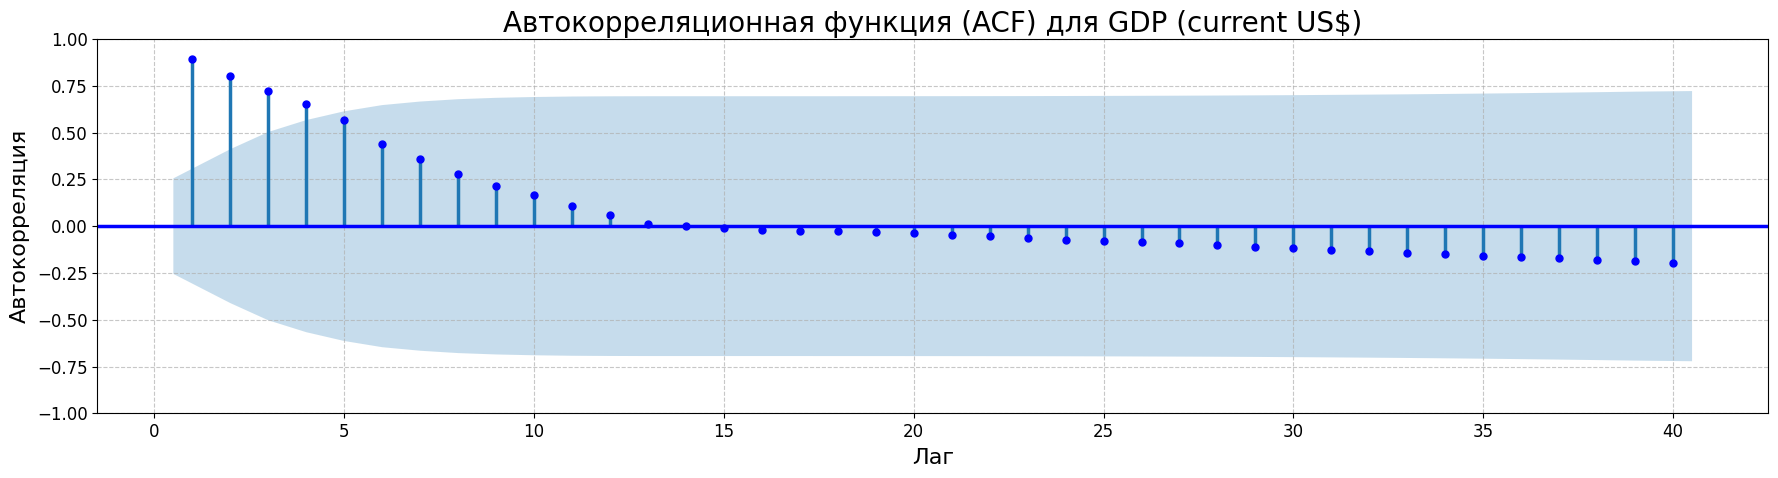

In [168]:
# Настройка параметров визуализации
plt.rcParams["figure.figsize"] = (18, 5);
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 2.5
# Построение графика ACF
plt.figure(figsize=(18, 5));
sgt.plot_acf(train_df['GDP (current US$)'], lags=40, zero=False, color='blue')

# Добавляем заголовок и подписи осей
plt.title("Автокорреляционная функция (ACF) для GDP (current US$)", fontsize=20, pad=5)
plt.xlabel("Лаг", fontsize=16, labelpad=5)
plt.ylabel("Автокорреляция", fontsize=16, labelpad=5)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.7)

# Улучшение внешнего вида осей
plt.tight_layout()
plt.show();

<Figure size 1800x500 with 0 Axes>

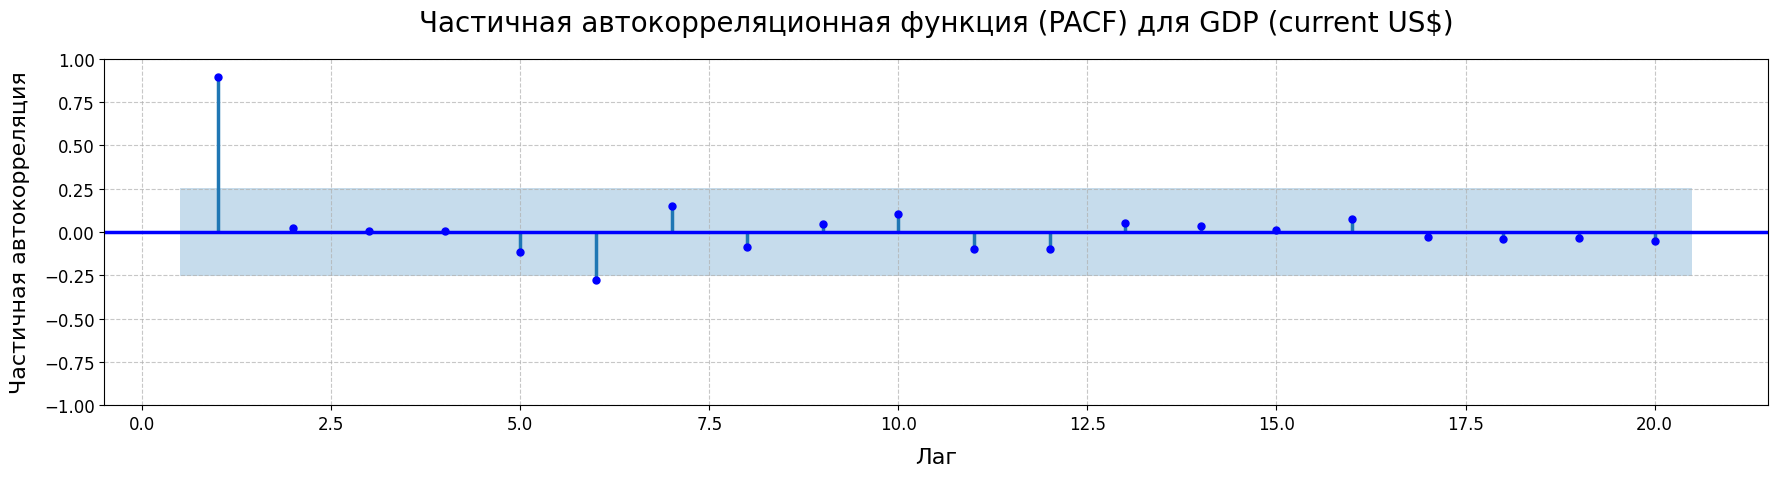

In [169]:
# Настройка параметров визуализации
plt.rcParams["figure.figsize"] = (18, 5);
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 2.5

# Построение графика PACF
plt.figure(figsize=(18, 5))
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False, color='blue')

plt.title("Частичная автокорреляционная функция (PACF) для GDP (current US$)", fontsize=20, pad=20)
plt.xlabel("Лаг", fontsize=16, labelpad=10)
plt.ylabel("Частичная автокорреляция", fontsize=16, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Параметр 'p' выбираем равным 1, так как по графику частичной автокорреляции PACF видно, что GPD с лагом не приносят никакой новой информации.

In [170]:
def adf_test(series, alpha=0.05):
    """
    Выполняет ADF-тест для временного ряда и выводит результаты.

    Параметры:
    ----------
    series : pd.Series
        Временной ряд для тестирования.
    alpha : float, optional (default=0.05)
        Уровень значимости для проверки гипотезы.

    Возвращает:
    ----------
    None
        Выводит результаты теста в консоль.
    """
    # Выполнение ADF-теста
    result = adfuller(series)

    # Извлечение результатов
    adf_statistic = result[0]
    p_value = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_values = result[4]

    # Вывод результатов
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {adf_statistic}")
    print(f"p-значение: {p_value}")
    print(f"Количество лагов: {used_lag}")
    print(f"Количество наблюдений: {n_obs}")
    print("Критические значения:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    # Интерпретация результата
    print("\nВывод: ADF-статистика ({}) {} всех критических значений.".format(
        adf_statistic,
        "больше" if adf_statistic > max(critical_values.values()) else "меньше"
    ))
    print("       p-значение ({}) {} {} => {} нулевую гипотезу.".format(
        p_value,
        ">=" if p_value >= alpha else "<",
        alpha,
        "не отвергаем" if p_value >= alpha else "отвергаем"
    ))
    print("       Ряд {}стационарен ({}).".format(
        "" if p_value < alpha else "не",
        "нет единичного корня" if p_value < alpha else "имеет единичный корень"
    ))


adf_test(train_df['GDP (current US$)'])

Результаты теста Дики-Фуллера:
ADF-статистика: 0.6529066974885405
p-значение: 0.9888496277665573
Количество лагов: 10
Количество наблюдений: 48
Критические значения:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777

Вывод: ADF-статистика (0.6529066974885405) больше всех критических значений.
       p-значение (0.9888496277665573) >= 0.05 => не отвергаем нулевую гипотезу.
       Ряд нестационарен (имеет единичный корень).


In [171]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=20)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

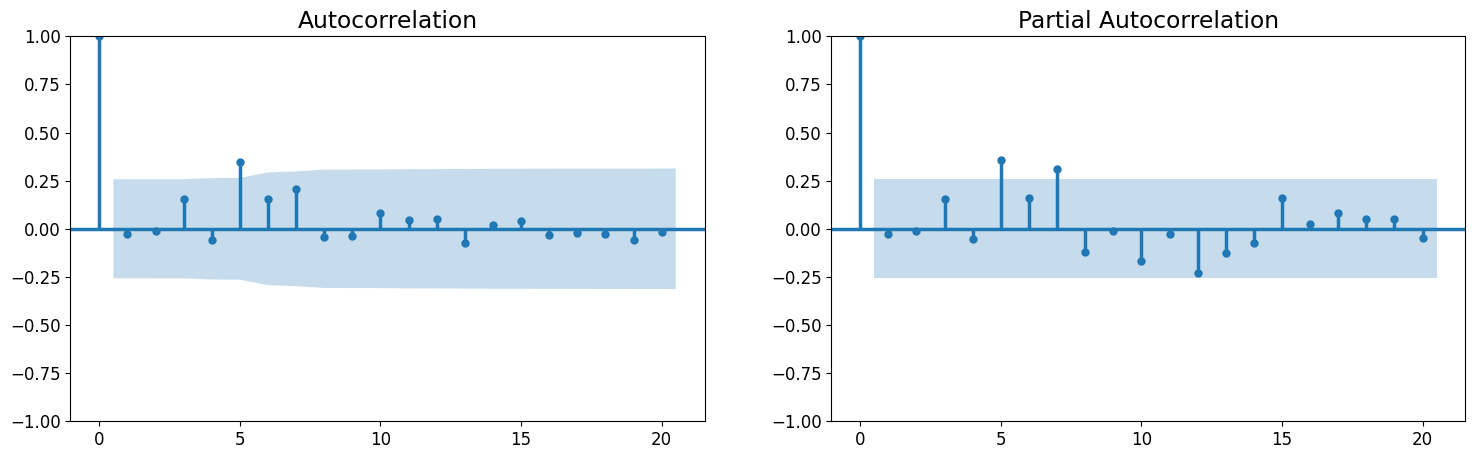

In [172]:
plot_acf_pacf(train_df['GDP (current US$)'].diff().dropna())

In [173]:
adf_test(train_df['GDP (current US$)'].diff().dropna())

Результаты теста Дики-Фуллера:
ADF-статистика: -1.670248303832082
p-значение: 0.44650293297138693
Количество лагов: 7
Количество наблюдений: 50
Критические значения:
   1%: -3.568485864
   5%: -2.92135992
   10%: -2.5986616

Вывод: ADF-статистика (-1.670248303832082) больше всех критических значений.
       p-значение (0.44650293297138693) >= 0.05 => не отвергаем нулевую гипотезу.
       Ряд нестационарен (имеет единичный корень).


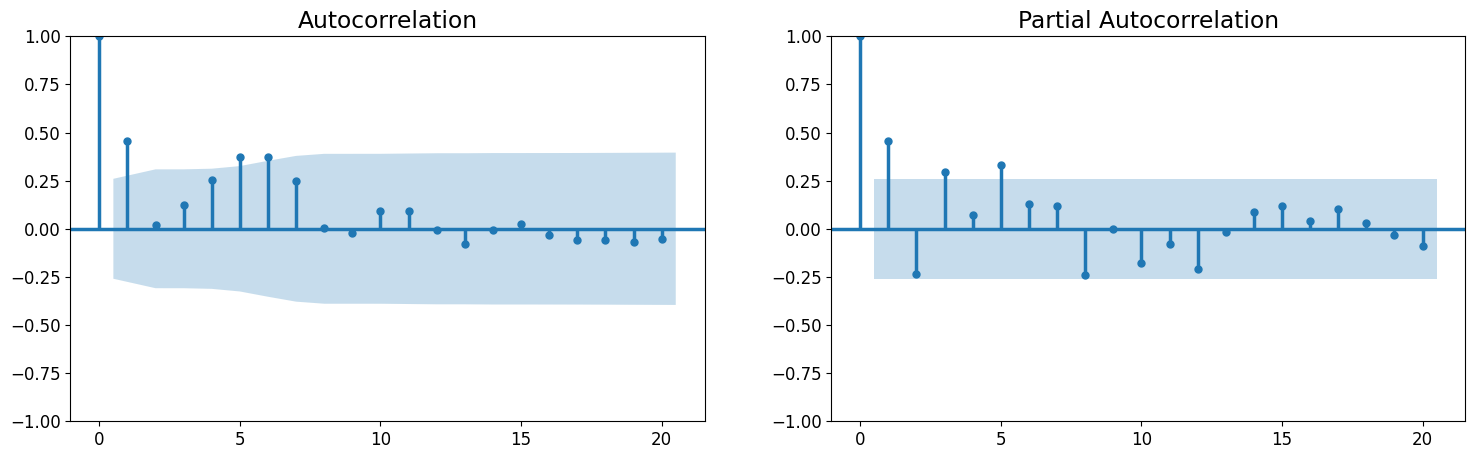

In [174]:
plot_acf_pacf(train_df['GDP (current US$)'].diff(2).dropna())

In [175]:
adf_test(train_df['GDP (current US$)'].diff(2).dropna())

Результаты теста Дики-Фуллера:
ADF-статистика: -3.5836708658260323
p-значение: 0.006080989753876896
Количество лагов: 11
Количество наблюдений: 45
Критические значения:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937

Вывод: ADF-статистика (-3.5836708658260323) меньше всех критических значений.
       p-значение (0.006080989753876896) < 0.05 => отвергаем нулевую гипотезу.
       Ряд стационарен (нет единичного корня).


Остановимся на вторых разностях

## ARIMA

Попробуем модель **ARIMA** с разными параметрами:


In [177]:
train_df = train_df.asfreq('YS')
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()


# Извлечение таблицы с коэффициентами
coef_table = arima_model_fit.summary().tables[1]

# Преобразование таблицы в удобный формат
headers = coef_table.data[0]
rows = coef_table.data[1:]

# Вывод таблицы с помощью tabulate
print("=" * 80)
print("Коэффициенты модели ARIMA(1, 2, 3)")
print("=" * 80)
print(tabulate(rows, headers=headers, tablefmt="pretty"))
print("=" * 80)
print(f"AIC: {arima_model_fit.aic}")
print(f"BIC: {arima_model_fit.bic}")
print("=" * 80)

Коэффициенты модели ARIMA(1, 2, 3)
+--------+----------+----------+---------+-------+----------+----------+
|        |   coef   | std err  |    z    | P>|z| |  [0.025  |  0.975]  |
+--------+----------+----------+---------+-------+----------+----------+
| ar.L1  | -0.1775  |  0.082   | -2.159  | 0.031 |  -0.339  |  -0.016  |
| ma.L1  | -0.8688  |  0.046   | -19.069 | 0.000 |  -0.958  |  -0.780  |
| sigma2 | 1.96e+19 | 2.13e-22 | 9.2e+40 | 0.000 | 1.96e+19 | 1.96e+19 |
+--------+----------+----------+---------+-------+----------+----------+
AIC: 2684.415773283555
BIC: 2690.544927087059


In [178]:
train_df = train_df.asfreq('YS')
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 2, 2))
arima_model_fit = arima_model.fit()


# Извлечение таблицы с коэффициентами
coef_table = arima_model_fit.summary().tables[1]

# Преобразование таблицы в удобный формат
headers = coef_table.data[0]
rows = coef_table.data[1:]

# Вывод таблицы с помощью tabulate
print("=" * 80)
print("Коэффициенты модели ARIMA(1, 2, 3)")
print("=" * 80)
print(tabulate(rows, headers=headers, tablefmt="pretty"))
print("=" * 80)
print(f"AIC: {arima_model_fit.aic}")
print(f"BIC: {arima_model_fit.bic}")
print("=" * 80)

Коэффициенты модели ARIMA(1, 2, 3)
+--------+----------+----------+----------+-------+----------+----------+
|        |   coef   | std err  |    z     | P>|z| |  [0.025  |  0.975]  |
+--------+----------+----------+----------+-------+----------+----------+
| ar.L1  |  0.4013  |  0.214   |  1.875   | 0.061 |  -0.018  |  0.821   |
| ma.L1  | -1.5544  |  0.220   |  -7.063  | 0.000 |  -1.986  |  -1.123  |
| ma.L2  |  0.6536  |  0.191   |  3.426   | 0.001 |  0.280   |  1.028   |
| sigma2 | 1.14e+19 | 2.14e-20 | 5.34e+38 | 0.000 | 1.14e+19 | 1.14e+19 |
+--------+----------+----------+----------+-------+----------+----------+
AIC: 2680.987629981022
BIC: 2689.1598350523604


In [179]:
train_df = train_df.asfreq('YS')
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2, 2, 2))
arima_model_fit = arima_model.fit()


# Извлечение таблицы с коэффициентами
coef_table = arima_model_fit.summary().tables[1]

# Преобразование таблицы в удобный формат
headers = coef_table.data[0]
rows = coef_table.data[1:]

# Вывод таблицы с помощью tabulate
print("=" * 80)
print("Коэффициенты модели ARIMA(2, 2, 2)")
print("=" * 80)
print(tabulate(rows, headers=headers, tablefmt="pretty"))
print("=" * 80)
print(f"AIC: {arima_model_fit.aic}")
print(f"BIC: {arima_model_fit.bic}")
print("=" * 80)

Коэффициенты модели ARIMA(2, 2, 2)
+--------+----------+----------+----------+-------+----------+----------+
|        |   coef   | std err  |    z     | P>|z| |  [0.025  |  0.975]  |
+--------+----------+----------+----------+-------+----------+----------+
| ar.L1  | -1.0516  |  0.067   | -15.748  | 0.000 |  -1.182  |  -0.921  |
| ar.L2  | -0.3640  |  0.091   |  -4.016  | 0.000 |  -0.542  |  -0.186  |
| ma.L1  |  0.1476  |  0.112   |  1.318   | 0.188 |  -0.072  |  0.367   |
| ma.L2  | -0.8519  |  0.123   |  -6.941  | 0.000 |  -1.092  |  -0.611  |
| sigma2 | 1.12e+19 | 1.85e-20 | 6.05e+38 | 0.000 | 1.12e+19 | 1.12e+19 |
+--------+----------+----------+----------+-------+----------+----------+
AIC: 2675.972130436041
BIC: 2686.187386775214


In [181]:
train_df = train_df.asfreq('YS')  # Для годовых данных

smodel = pm.auto_arima(
    train_df['GDP (current US$)'].dropna(),
    start_p=0,
    d=2,
    start_q=0,
    max_p=6,
    max_q=6,
    test="adf",
    error_action="ignore",
    trace=True,
    stepwise=False,  # Отключаем шаговый поиск
)
# Вывод результатов
print("=" * 80)
print("Результаты автоматического подбора ARIMA модели")
print("=" * 80)
print(smodel.summary())

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=2719.959, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=2683.622, Time=0.52 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=2681.414, Time=0.27 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=2686.992, Time=0.27 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=2688.234, Time=0.65 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=2687.890, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=2704.667, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=2684.416, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=2680.988, Time=0.49 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=2680.765, Time=0.57 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=2682.800, Time=0.64 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=2693.079, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=2683.782, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=1.06 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=2682.648, Time=0.73 sec
 ARIMA(3,2,0)(0

* С помощью ручного подбора - лучшая по показателям AIC и BIC является модель ARIMA (2, 2, 2). С помощью автоматического подбора не удалось расчитать метрики для этих параметров.
* С помощью автоматической подборки, лучшая модель с параметрами (5, 2, 0)

**Отрисуем на графике обе модели и сравним их.**

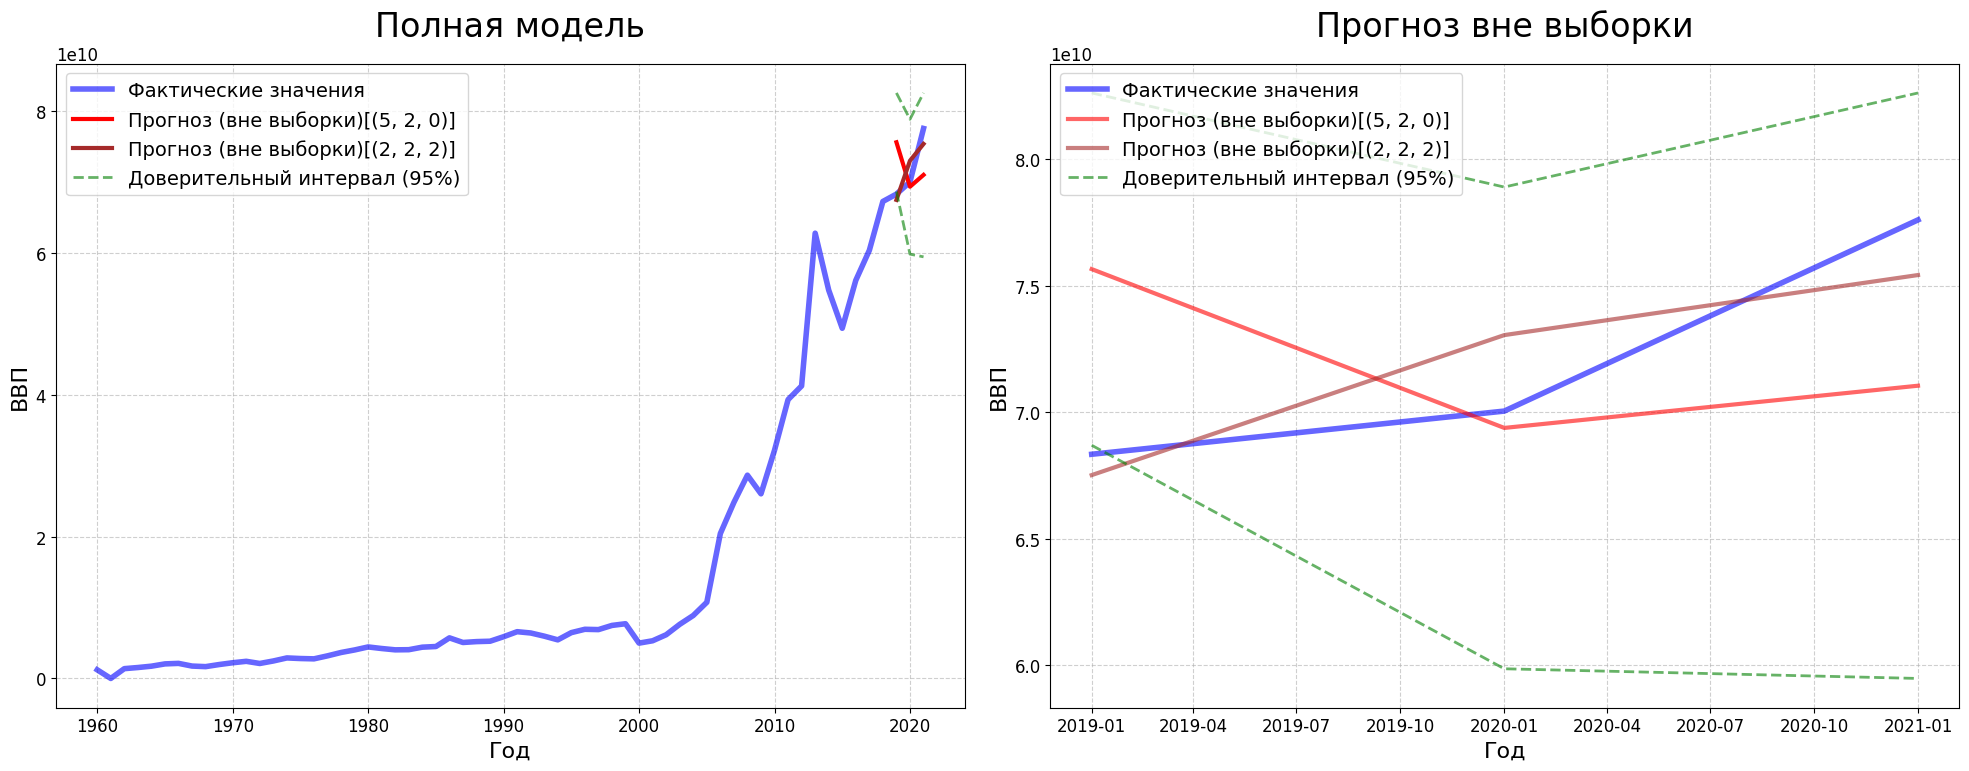

In [182]:
# Обучаем первую модель ARIMA на тренировочных данных
model_1 = ARIMA(train_df['GDP (current US$)'], order=(5, 2, 0))
model_fit_1 = model_1.fit()

# Обучаем вторую модель ARIMA на тренировочных данных
model_2 = ARIMA(train_df['GDP (current US$)'], order=(2, 2, 2))
model_fit_2 = model_2.fit()


predictions_1 = model_fit_1.predict(start=test_df.index[0], end=test_df.index[-1])
predictions_2 = model_fit_2.predict(start=test_df.index[0], end=test_df.index[-1])


predictions_1 = predictions_1.asfreq('YS')
predictions_2 = predictions_2.asfreq('YS')


forecast_1 = model_fit_1.get_forecast(steps=len(test_df))
forecast_df_1 = forecast_1.conf_int(alpha=0.05)

# Создаем DataFrame для визуализации
pred_df = pd.DataFrame(index=data.index)
pred_df["gdp"] = data['GDP (current US$)']
pred_df.loc[test_df.index, "model_preds"] = predictions_1
pred_df.loc[test_df.index, "model_preds_2"] = predictions_2
pred_df.loc[test_df.index, "model_preds_lower"] = forecast_df_1.iloc[:, 0]
pred_df.loc[test_df.index, "model_preds_upper"] = forecast_df_1.iloc[:, 1]

# Настройка размера фигуры и стиля
plt.rcParams["figure.figsize"] = 20, 8
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 16

# Первый график: Full Model Fit
plt.subplot(1, 2, 1)
plt.plot(pred_df["gdp"], color="blue", label="Фактические значения", alpha=0.6, linewidth=4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color="red", linestyle="-", label="Прогноз (вне выборки)[(5, 2, 0)]", linewidth=3)
plt.plot(pred_df.loc[test_df.index]["model_preds_2"], color="brown", linestyle="-", label="Прогноз (вне выборки)[(2, 2, 2)]", linewidth=3)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green", linestyle="--", label="Доверительный интервал (95%)", alpha=0.6, linewidth=2)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color="green", linestyle="--", alpha=0.6, linewidth=2)
plt.title("Полная модель", size=24, pad=20)
plt.xlabel("Год", size=16)
plt.ylabel("ВВП", size=16)
plt.legend(fontsize=14, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)

# Второй график: Out of Sample Fit
plt.subplot(1, 2, 2)
plt.plot(pred_df.loc[test_df.index]["gdp"], color="blue", label="Фактические значения", alpha=0.6, linewidth=4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color="red", linestyle="-", label="Прогноз (вне выборки)[(5, 2, 0)]", alpha=0.6, linewidth=3)
plt.plot(pred_df.loc[test_df.index]["model_preds_2"], color="brown", linestyle="-", label="Прогноз (вне выборки)[(2, 2, 2)]", alpha=0.6, linewidth=3)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green", linestyle="--", label="Доверительный интервал (95%)", alpha=0.6, linewidth=2)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color="green", linestyle="--", alpha=0.6, linewidth=2)
plt.title("Прогноз вне выборки", size=24, pad=20)
plt.xlabel("Год", size=16)
plt.ylabel("ВВП", size=16)
plt.legend(fontsize=14, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()


Обе модели тренд уловили очень плохо.

Модель с параметрами(2,2,2) ближе к фактическим значениям, но график показывает обратный тренд к фактическому.
Модель с параметрами(5,2,0) после 2020 года имеет похожий тренд. В целом если бы этот график развернуть под другим углом, то график был бы очень близок к фактическим значениям.


# **Интерполяция**

In [183]:
data = data.rename(columns={'GDP (current US$)': 'gdp'})
data['gdp'] = data['gdp'].replace(0, np.nan)

# Применяем asfreq для годовой частоты
df_annual = data.asfreq(freq='YS')


print("Данные с годовой частотой:")
print(df_annual.head(5))

print("\nПропуски в данных:")
print(df_annual.isnull().sum())

Данные с годовой частотой:
                     gdp
year                    
1960-01-01  1.217087e+09
1961-01-01           NaN
1962-01-01  1.382353e+09
1963-01-01  1.540616e+09
1964-01-01  1.731092e+09

Пропуски в данных:
gdp    1
dtype: int64


Заполняем пропуски с помощью интерполяции.

In [184]:
interpolated_data = pd.DataFrame(data['gdp'].interpolate(method='linear'), columns=['gdp'])

In [185]:
train_df = interpolated_data.iloc[:-3]
test_df = interpolated_data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Проводим тест Дики-Фуллера, чтобы проверить стационарность ряда.

In [186]:
adf_test(train_df['gdp'])

Результаты теста Дики-Фуллера:
ADF-статистика: 0.8030073326980115
p-значение: 0.9916845572455877
Количество лагов: 10
Количество наблюдений: 48
Критические значения:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777

Вывод: ADF-статистика (0.8030073326980115) больше всех критических значений.
       p-значение (0.9916845572455877) >= 0.05 => не отвергаем нулевую гипотезу.
       Ряд нестационарен (имеет единичный корень).


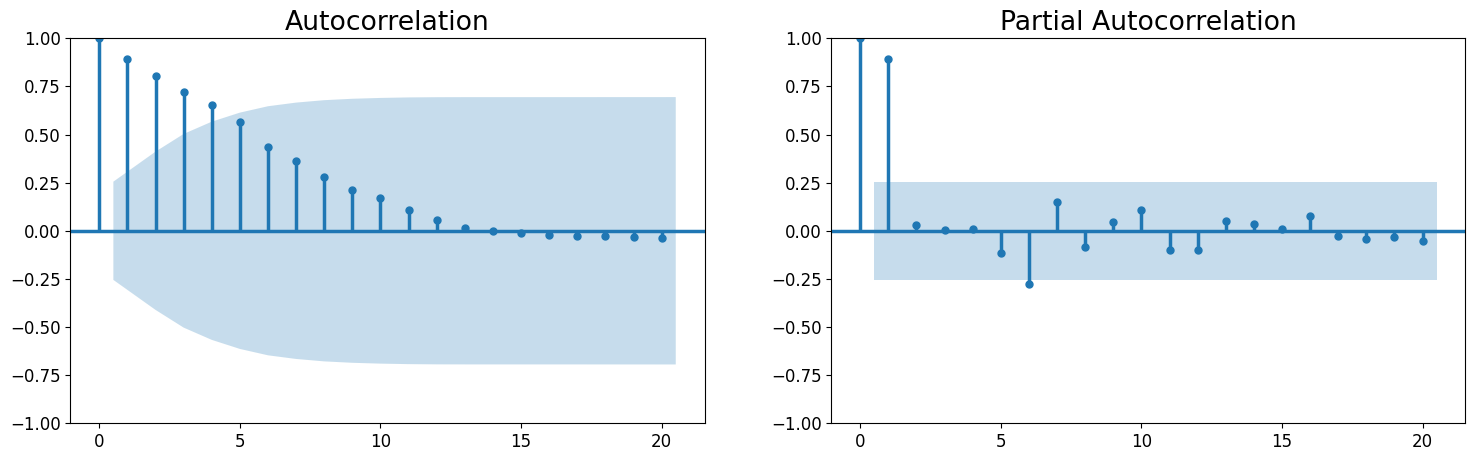

In [187]:
plot_acf_pacf(train_df['gdp'])

In [188]:
adf_test(train_df['gdp'].diff().dropna())

Результаты теста Дики-Фуллера:
ADF-статистика: -1.8255652246436
p-значение: 0.36784515276563423
Количество лагов: 7
Количество наблюдений: 50
Критические значения:
   1%: -3.568485864
   5%: -2.92135992
   10%: -2.5986616

Вывод: ADF-статистика (-1.8255652246436) больше всех критических значений.
       p-значение (0.36784515276563423) >= 0.05 => не отвергаем нулевую гипотезу.
       Ряд нестационарен (имеет единичный корень).


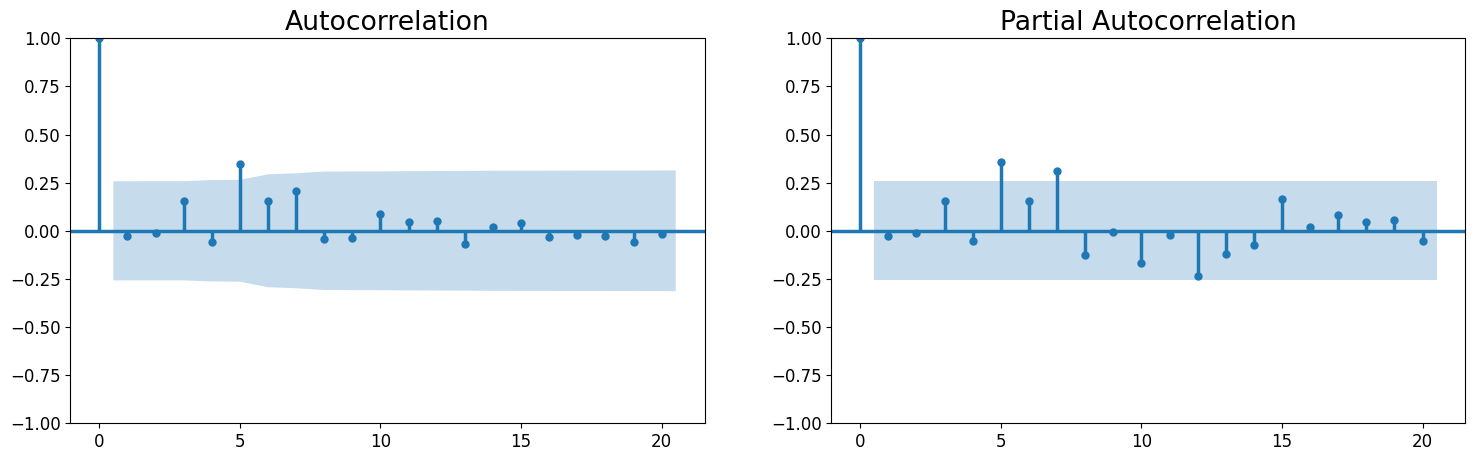

In [189]:
plot_acf_pacf(train_df['gdp'].diff().dropna())

In [190]:
adf_test(train_df['gdp'].diff(2).dropna())

Результаты теста Дики-Фуллера:
ADF-статистика: -3.999803440949154
p-значение: 0.0014115408436661007
Количество лагов: 11
Количество наблюдений: 45
Критические значения:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937

Вывод: ADF-статистика (-3.999803440949154) меньше всех критических значений.
       p-значение (0.0014115408436661007) < 0.05 => отвергаем нулевую гипотезу.
       Ряд стационарен (нет единичного корня).


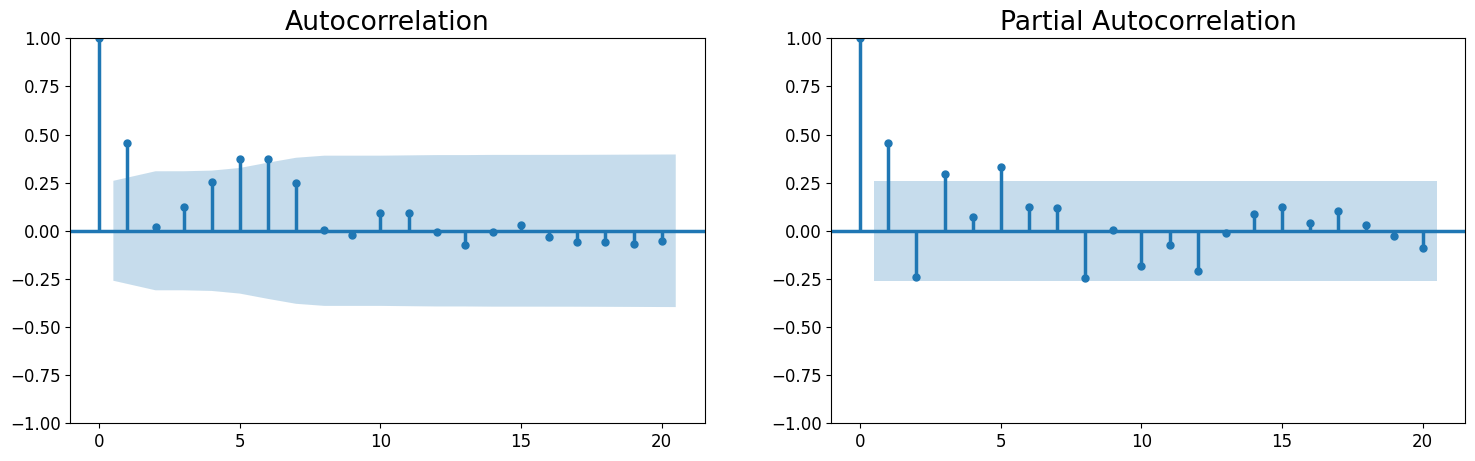

In [191]:
plot_acf_pacf(train_df['gdp'].diff(2).dropna())

Принимаем вторые разности.

По графикам автокорреляции и частичной автокоррляции оптимальными будут параметры :

* p = 4
* q = 1

Проверим какие параметры подберем через библиотеку автоматического подбора параметров.

In [192]:
train_df = train_df.asfreq('YS')  # Для годовых данных

smodel = pm.auto_arima(
    train_df['gdp'],
    start_p=0,
    d=2,
    start_q=0,
    max_p=6,
    max_q=6,
    test="adf",
    error_action="ignore",
    trace=True,
    stepwise=False,  # Отключаем шаговый поиск
)
# Вывод результатов
print("=" * 80)
print("Результаты автоматического подбора ARIMA модели")
print("=" * 80)
print(smodel.summary())

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=2719.683, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=2683.547, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=2681.389, Time=0.24 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=2687.184, Time=0.21 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=2687.812, Time=0.69 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=2687.881, Time=0.81 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=2704.584, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=2684.377, Time=0.57 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=2680.921, Time=0.84 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=2680.513, Time=1.04 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=2682.617, Time=0.74 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=2692.971, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=2683.709, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.68 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=2682.393, Time=0.59 sec
 ARIMA(3,2,0)(0

Получили такой же результат.

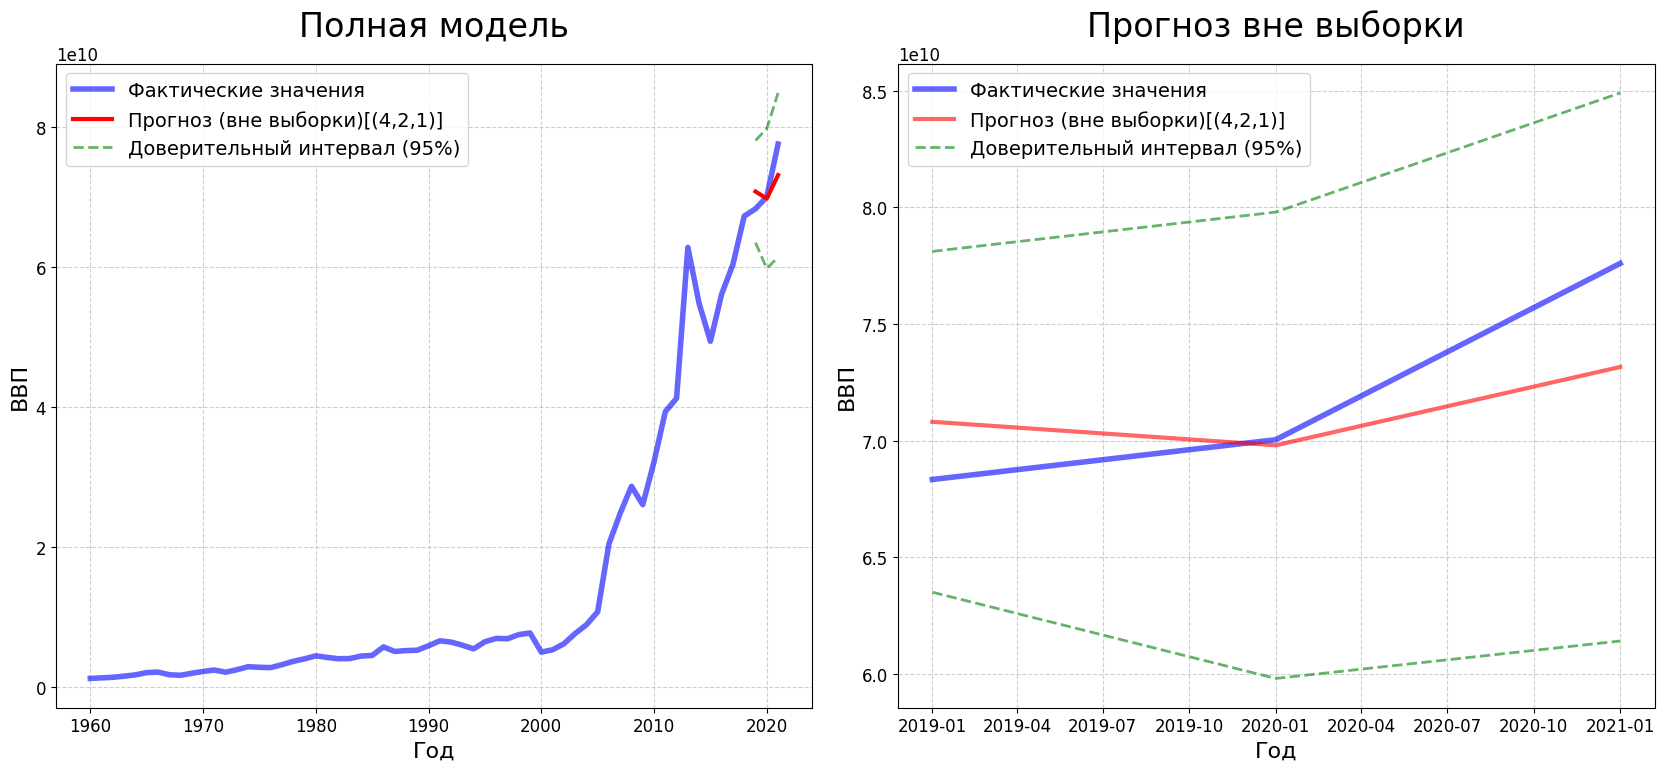

In [193]:
model_1 = ARIMA(train_df['gdp'], order=(4, 2, 1))
model_fit_1 = model_1.fit()

predictions_1 = model_fit_1.predict(start=test_df.index[0], end=test_df.index[-1])
predictions_1 = predictions_1.asfreq('YS')

forecast_1 = model_fit_1.get_forecast(steps=len(test_df))
forecast_df_1 = forecast_1.conf_int(alpha=0.05)

pred_df = pd.DataFrame(index=interpolated_data.index)
pred_df["gdp"] = interpolated_data['gdp']
pred_df.loc[test_df.index, "model_preds"] = predictions_1
pred_df.loc[test_df.index, "model_preds_lower"] = forecast_df_1.iloc[:, 0]
pred_df.loc[test_df.index, "model_preds_upper"] = forecast_df_1.iloc[:, 1]

# Настройка размера фигуры и стиля
plt.rcParams["figure.figsize"] = 17, 8
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 16

# Первый график:
plt.subplot(1, 2, 1)
plt.plot(pred_df["gdp"], color="blue", label="Фактические значения", alpha=0.6, linewidth=4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color="red", linestyle="-", label="Прогноз (вне выборки)[(4,2,1)]", linewidth=3)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green", linestyle="--", label="Доверительный интервал (95%)", alpha=0.6, linewidth=2)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color="green", linestyle="--", alpha=0.6, linewidth=2)
plt.title("Полная модель", size=24, pad=20)
plt.xlabel("Год", size=16)
plt.ylabel("ВВП", size=16)
plt.legend(fontsize=14, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)

# Второй график:
plt.subplot(1, 2, 2)
plt.plot(pred_df.loc[test_df.index]["gdp"], color="blue", label="Фактические значения", alpha=0.6, linewidth=4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color="red", linestyle="-", label="Прогноз (вне выборки)[(4,2,1)]", alpha=0.6, linewidth=3)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green", linestyle="--", label="Доверительный интервал (95%)", alpha=0.6, linewidth=2)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color="green", linestyle="--", alpha=0.6, linewidth=2)
plt.title("Прогноз вне выборки", size=24, pad=20)
plt.xlabel("Год", size=16)
plt.ylabel("ВВП", size=16)
plt.legend(fontsize=14, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()

Благодаря интерполяции и подбору параметров для ARIMA получили график намного лучше, чем с моделью на неинтерполированных данных.

Теперь график с параметрами ARIMA(4, 2, 1) намного лучше уловил тренд, и значения стали больше приближены к фактическим.

# **Волатильность**

In [194]:
data['gdp_vol'] = data['gdp'].pct_change(1).mul(100).abs()
data['gdp_vol'].head()

,gdp_vol
year,
1960-01-01,NaN
1961-01-01,0.000000
1962-01-01,13.578826
1963-01-01,11.448835
1964-01-01,12.363636


<Axes: xlabel='year'>

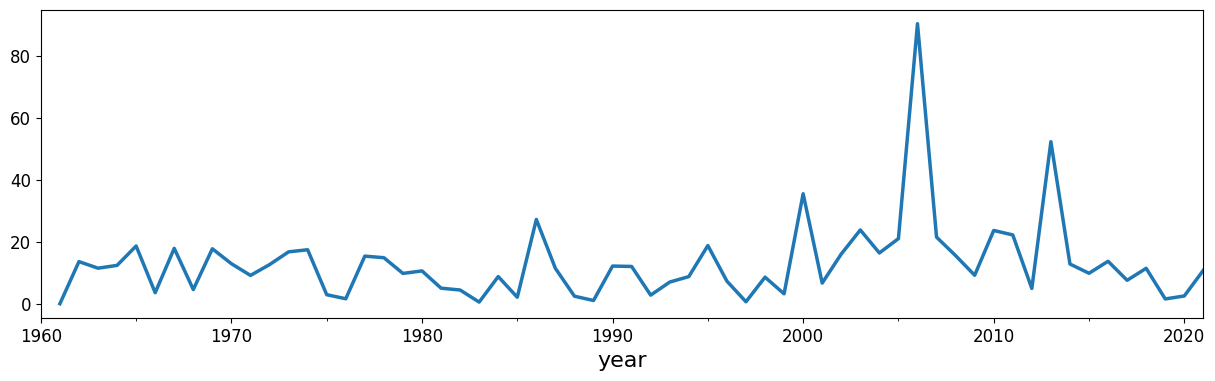

In [61]:
data['gdp_vol'].plot()

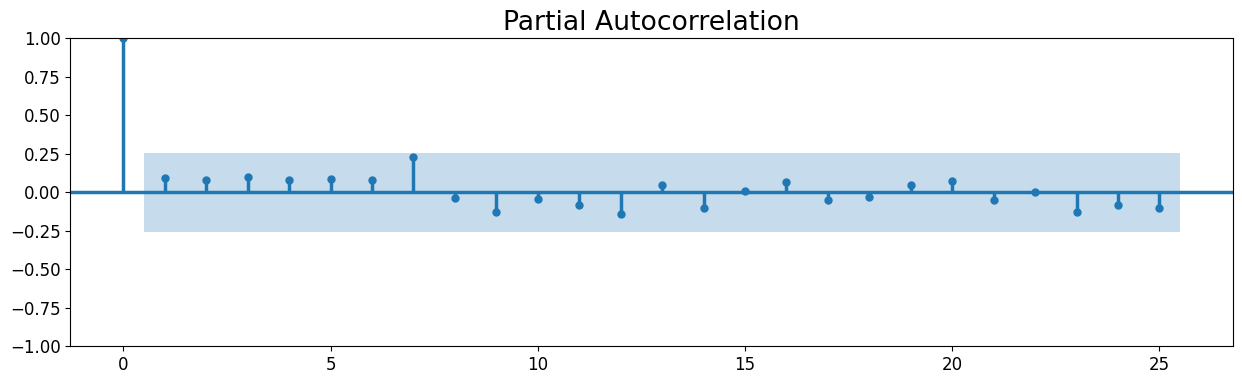

In [195]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

plt.rcParams['figure.figsize'] = 15, 4

sgt.plot_pacf(train_df['gdp_vol'][1:], lags=25)
plt.show()

In [64]:
adf_test(train_df['gdp_vol'][1:])

Результаты теста Дики-Фуллера:
ADF-статистика: -6.816105099260228
p-значение: 2.0572875762632108e-09
Количество лагов: 0
Количество наблюдений: 57
Критические значения:
   1%: -3.5506699942762414
   5%: -2.913766394626147
   10%: -2.5946240473991997

Вывод: ADF-статистика (-6.816105099260228) меньше всех критических значений.
       p-значение (2.0572875762632108e-09) < 0.05 => отвергаем нулевую гипотезу.
       Ряд стационарен (нет единичного корня).


Построим модель GARCH(1, 1)

Важно сохранить объем датасета, поэтому берем весь датасет с индексами, который содержит и train и test часть.

In [196]:
garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index])

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

In [197]:
model = arch_model(garch_df['gdp_vol'].dropna(), p=1, q=1, vol='GARCH')
model_res = model.fit(last_obs=test_df.index[0], update_freq=3)

Iteration:      3,   Func. Count:     17,   Neg. LLF: 231.218355263236
Iteration:      6,   Func. Count:     33,   Neg. LLF: 248.60836375264788
Iteration:      9,   Func. Count:     51,   Neg. LLF: 247.90930186195428
Iteration:     12,   Func. Count:     69,   Neg. LLF: 230.02156533737218
Iteration:     15,   Func. Count:     85,   Neg. LLF: 227.61391659426832
Iteration:     18,   Func. Count:    100,   Neg. LLF: 227.4836138797677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 227.4836118733976
            Iterations: 20
            Function evaluations: 109
            Gradient evaluations: 20


In [71]:
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -227.484
Distribution:                  Normal   AIC:                           462.967
Method:            Maximum Likelihood   BIC:                           471.209
                                        No. Observations:                   58
Date:                Fri, Mar 07 2025   Df Residuals:                       57
Time:                        21:06:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3708      2.367      5.227  1.727e-07 [  7.732, 17.010]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.5718     23.315      0.153      0.878 [-42.125, 49.269]
alpha[1]       0.0000  8.441e-02      0.000      1.000 [ -0.165,  0.165]
beta[1]        1.0000      0.144      6.929  4.240e-12 [  0.717,  1.283]
========================================================================

Covariance estimator: robust
"""

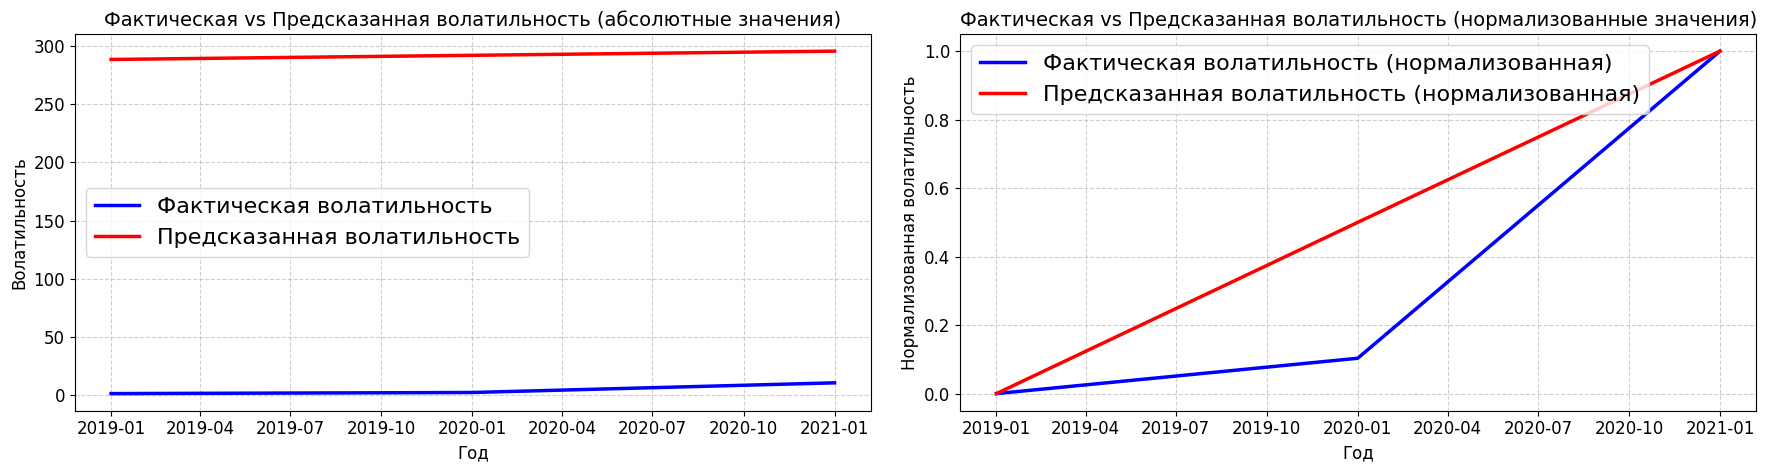

In [204]:
predictions_df = test_df.copy()
predictions_df['predictions'] = model_res.forecast().residual_variance.loc[test_df.index]

# Нормализация данных
predictions_df['gdp_vol_normalized'] = (predictions_df['gdp_vol'] - predictions_df['gdp_vol'].min()) / (predictions_df['gdp_vol'].max() - predictions_df['gdp_vol'].min())
predictions_df['predictions_normalized'] = (predictions_df['predictions'] - predictions_df['predictions'].min()) / (predictions_df['predictions'].max() - predictions_df['predictions'].min())

plt.rcParams['figure.figsize'] = 18, 5

# График 1: Абсолютные значения
plt.subplot(1, 2, 1)
plt.plot(predictions_df['gdp_vol'].abs(), label='Фактическая волатильность', color='blue')
plt.plot(predictions_df['predictions'], label='Предсказанная волатильность', color='red')
plt.title('Фактическая vs Предсказанная волатильность (абсолютные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Волатильность', size=12)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.grid(True, linestyle='--', alpha=0.6)

# График 2: Нормализованные значения
plt.subplot(1, 2, 2)
plt.plot(predictions_df['gdp_vol_normalized'], label='Фактическая волатильность (нормализованная)', color='blue')
plt.plot(predictions_df['predictions_normalized'], label='Предсказанная волатильность (нормализованная)', color='red')
plt.title('Фактическая vs Предсказанная волатильность (нормализованные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Нормализованная волатильность', size=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()

In [205]:
print(np.sqrt(mean_squared_error(predictions_df['gdp_vol'], predictions_df['predictions'])))
print(r2_score(predictions_df['gdp_vol'], predictions_df['predictions']))

286.93471971512145
-4783.174916925412


Модель смогла уловить только направление изменений, но не уловила диспрерсию и предсказанные значения далеки от фактических. Коэффициент детерминации значительно ниже 1, что говорит о том, что предсказание работает хуже, чем простое предсказание средним значением.

Попробуем предсказать с помощью линейной регрессии

## ЛИНЕЙНАЯ РЕГРЕССИЯ

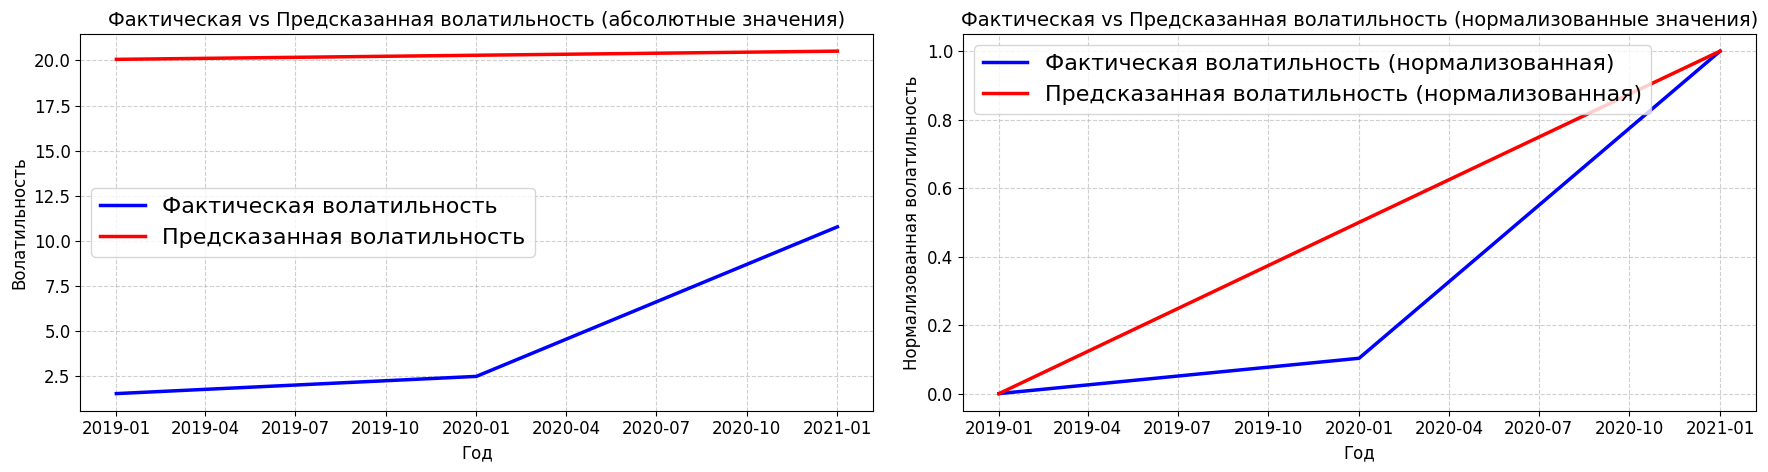

In [206]:
X_train = pd.DataFrame(range(data['gdp_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['gdp_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['gdp_vol'].fillna(0)
y_test = test_df['gdp_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

predictions_df = test_df.copy()
predictions_df['predictions'] = lr_predict

# Нормализация данных
predictions_df['gdp_vol_normalized'] = (predictions_df['gdp_vol'] - predictions_df['gdp_vol'].min()) / (predictions_df['gdp_vol'].max() - predictions_df['gdp_vol'].min())
predictions_df['predictions_normalized'] = (predictions_df['predictions'] - predictions_df['predictions'].min()) / (predictions_df['predictions'].max() - predictions_df['predictions'].min())


plt.rcParams['figure.figsize'] = 18, 5

# График 1: Абсолютные значения
plt.subplot(1, 2, 1)
plt.plot(predictions_df['gdp_vol'], label='Фактическая волатильность', color='blue')
plt.plot(predictions_df['predictions'], label='Предсказанная волатильность', color='red')
plt.title('Фактическая vs Предсказанная волатильность (абсолютные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Волатильность', size=12)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.grid(True, linestyle='--', alpha=0.6)

# График 2: Нормализованные значения
plt.subplot(1, 2, 2)
plt.plot(predictions_df['gdp_vol_normalized'], label='Фактическая волатильность (нормализованная)', color='blue')
plt.plot(predictions_df['predictions_normalized'], label='Предсказанная волатильность (нормализованная)', color='red')
plt.title('Фактическая vs Предсказанная волатильность (нормализованные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Нормализованная волатильность', size=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()

In [207]:
print(np.sqrt(mean_squared_error(y_test, lr_predict)))
print(r2_score(y_test, lr_predict))

15.854481999373059
-13.606459547628749


По графику видно, что предсказанная волатильность не смогла полностью уловить резкий рост фактической волатильности. Однако модель все же смогла уловить общее направление изменений, и предсказанные значения оказались ближе к фактическим по сравнению с результатами, полученными с помощью модели GARCH.
Также коэффициент детерминации стал больше, хотя и значительно ниже 1 (что опять же говорит о том, что моедль предсказывает хуже, чем простым средним).
Из-за того, что такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке.

# **Prophet**

In [208]:
df = pd.read_csv("https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip", compression='zip')

df['year'] = pd.to_datetime(df['year'])
df.columns = ['ds', 'y']
df = df.fillna(0)
# Разделяем данные на тренировочную и тестовую части
train = df.iloc[:-3]
test = df.iloc[-3:]

# Создаем и обучаем модель Prophet
model = Prophet()
model.fit(train)

forecast = model.predict(test[['ds']])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgzlo78jf/x7e0dzei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgzlo78jf/zd1xq_og.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24', 'data', 'file=/tmp/tmpgzlo78jf/x7e0dzei.json', 'init=/tmp/tmpgzlo78jf/zd1xq_og.json', 'output', 'file=/tmp/tmpgzlo78jf/prophet_modelg5y9hl7v/prophet_model-20250307230619.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:06:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


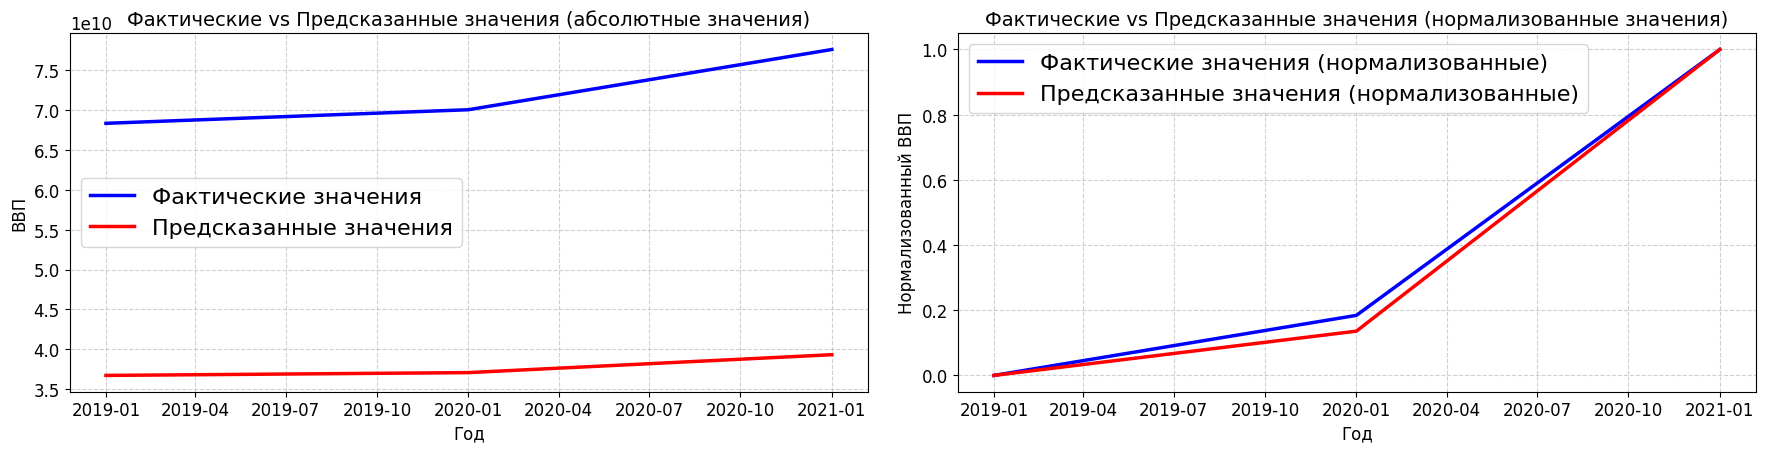

In [209]:
# Объединяем фактические и предсказанные значения
predictions_df = test.copy()
predictions_df['predictions'] = forecast['yhat'].values

predictions_df['y_normalized'] = (predictions_df['y'] - predictions_df['y'].min()) / (predictions_df['y'].max() - predictions_df['y'].min())
predictions_df['predictions_normalized'] = (predictions_df['predictions'] - predictions_df['predictions'].min()) / (predictions_df['predictions'].max() - predictions_df['predictions'].min())

plt.rcParams['figure.figsize'] = 18, 5

# График 1: Абсолютные значения
plt.subplot(1, 2, 1)
plt.plot(predictions_df['ds'], predictions_df['y'], label='Фактические значения', color='blue')
plt.plot(predictions_df['ds'], predictions_df['predictions'], label='Предсказанные значения', color='red')
plt.title('Фактические vs Предсказанные значения (абсолютные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('ВВП', size=12)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.grid(True, linestyle='--', alpha=0.6)

# График 2: Нормализованные значения
plt.subplot(1, 2, 2)
plt.plot(predictions_df['ds'], predictions_df['y_normalized'], label='Фактические значения (нормализованные)', color='blue')
plt.plot(predictions_df['ds'], predictions_df['predictions_normalized'], label='Предсказанные значения (нормализованные)', color='red')
plt.title('Фактические vs Предсказанные значения (нормализованные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Нормализованный ВВП', size=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()


In [210]:
print(np.sqrt(mean_squared_error(predictions_df['y'], predictions_df['predictions'])))
print(r2_score(predictions_df['y'], predictions_df['predictions']))

34394271793.66336
-72.11519149352121


Коэффициент детерминации хуже, чем у линейной регресии. Но модель идеально уловила тренд.

# **NeuralProphet**

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.305% of the data.
INFO:NP.df_utils:Major frequency YS corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO:NP.df_utils:Defined frequency is equal to major frequency - YS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with dai

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (8) is too small than the required number                     for the learning rate finder (205). The results might not be optimal.


Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.305% of the data.
INFO:NP.df_utils:Major frequency YS corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO:NP.df_utils:Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 66.667% of the data.
INFO:NP.df_utils:Major frequency YS corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq YS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 66.667% of the dat

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


RMSE: 1193109812.2956
MAE: 998089248.3204
R²: 0.9120


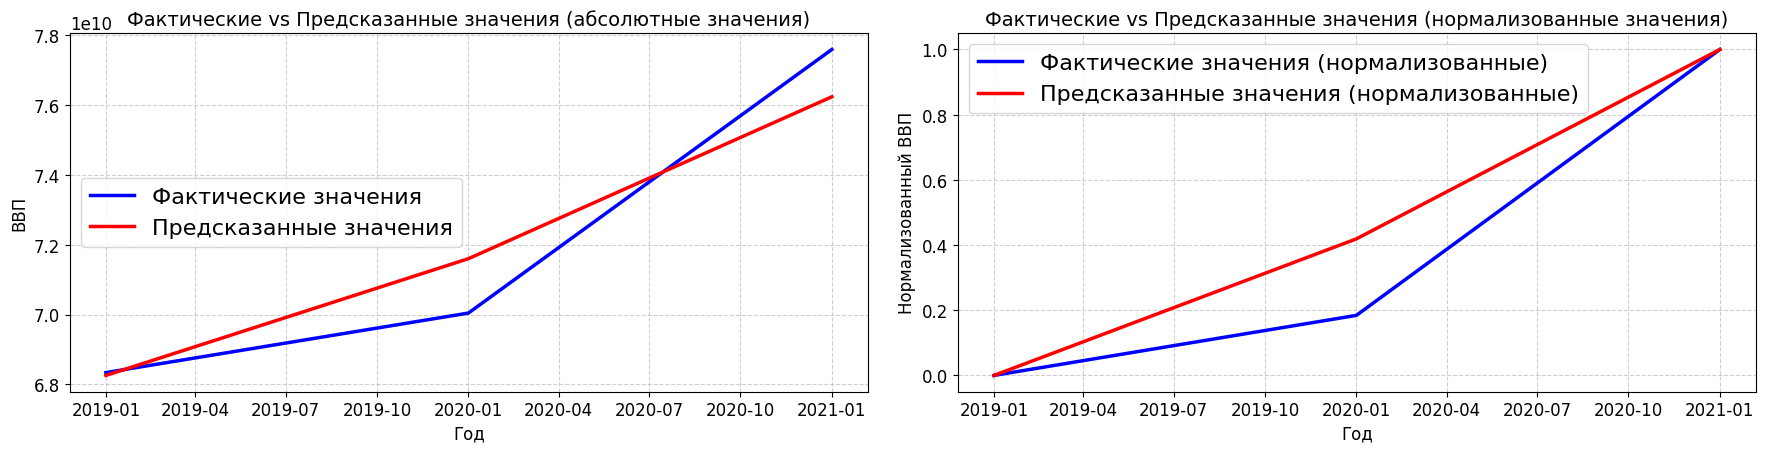

In [212]:
df = pd.read_csv("https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip", compression='zip')


df['year'] = pd.to_datetime(df['year'])
df.columns = ['ds', 'y']

# Разделяем данные на тренировочную и тестовую части
train = df.iloc[:-3]
test = df.iloc[-3:]

# Создаем и обучаем модель NeuralProphet
model = NeuralProphet()
model.fit(train, freq='YS')

# Делаем прогноз для тестовых данных
future = model.make_future_dataframe(train, periods=3)
forecast = model.predict(future)

# Объединяем фактические и предсказанные значения
predictions_df = test.copy()
predictions_df['predictions'] = forecast['yhat1'].values

# Нормализация данных
predictions_df['y_normalized'] = (predictions_df['y'] - predictions_df['y'].min()) / (predictions_df['y'].max() - predictions_df['y'].min())
predictions_df['predictions_normalized'] = (predictions_df['predictions'] - predictions_df['predictions'].min()) / (predictions_df['predictions'].max() - predictions_df['predictions'].min())


y_true = predictions_df['y']
y_pred = predictions_df['predictions']


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Вывод ошибок
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


plt.rcParams['figure.figsize'] = 18, 5

# График 1: Абсолютные значения
plt.subplot(1, 2, 1)
plt.plot(predictions_df['ds'], predictions_df['y'], label='Фактические значения', color='blue')
plt.plot(predictions_df['ds'], predictions_df['predictions'], label='Предсказанные значения', color='red')
plt.title('Фактические vs Предсказанные значения (абсолютные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('ВВП', size=12)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.grid(True, linestyle='--', alpha=0.6)

# График 2: Нормализованные значения
plt.subplot(1, 2, 2)
plt.plot(predictions_df['ds'], predictions_df['y_normalized'], label='Фактические значения (нормализованные)', color='blue')
plt.plot(predictions_df['ds'], predictions_df['predictions_normalized'], label='Предсказанные значения (нормализованные)', color='red')
plt.title('Фактические vs Предсказанные значения (нормализованные значения)', size=14)
plt.xlabel('Год', size=12)
plt.ylabel('Нормализованный ВВП', size=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()


С помощью NeuralProphet наконец получили хорошее предсказание, r2_score теперь близок к. И на графике также видно, что предсказанные значения близко расположены к фактическим, а также модель достаточно хорошо уловила тренд.